# **Algorytm Genetyczcny - Problem Komiwojażera**
Projekt przedstawia implememntację działania algorytmu genetycznego na klasycznym problemie polegającym na znalezieniu najkrótszej trasy odwiedzającej każde z `n` miast dokładnie raz i powracającej do punktu startowego.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import random
import time

#### **Generowanie punktów**
Funkcja `generate_cities` generuje współrzędne **n** miast rozmieszczonych równomiernie na okręgu o zadanym promieniu i środku. Każde miasto reprezentowane jest jako punkt (x, y) na płaszczyźnie.

Punkty są generowane na okręgu, a nie losowo, aby od razu wiadomo było jaka jest optymalna trasa, oraz aby wyraźniej było widać jej optymalizację w kolejnych pokoleniach.

In [2]:
def generate_cities(n=10, radius=250, center=(0, 0)):
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    cities = [(center[0] + radius * np.cos(a), center[1] + radius * np.sin(a)) for a in angles]
    return cities

#### **Generowanie początkowej populacji**
Funkcja `initialize_population` inicjalizuje początkową populację losowych tras o rozmiarze `population_size`. Większy rozmiar daje większą różnorodność, co zmniejsza ryzyko utknięcia w ekstremum lokalnym, ale zwiększa ilość obliczeń. Mniejsza populacja przyspiesza działanie algorytmu, lecz istnieje większe ryzyko zbieżności do ekstremum lokalnego.

Funkcja zwraca listy indeksów miast (lista, której elementami są listy).

In [3]:
def initialize_population(n_cities, population_size=100):
    population = []
    for _ in range(population_size):
        individual = list(np.random.permutation(n_cities))
        population.append(individual)
    return population

#### **Obliczanie dystansu**
Funkcja `calculate_distance` oblicza długość pojedynczej trasy (osobnika). Jako argumenty przyjmuje trasę (`path`) w postaci listy indeksów kolejnych miast oraz współrzędne wszystkich miast (`cities`).

Funkcja `optimal_path_distance` oblicza długość optymalnej trasy, czyli w praktyce obwód n-kątu foremnego (n - ilość miast).

In [4]:
def calculate_distance(path, cities):
    distance = 0.0
    for i in range(len(path)):
        city_a = cities[path[i]]
        city_b = cities[path[(i + 1) % len(path)]]  # wracamy do punktu startowego
        distance += np.linalg.norm(np.array(city_a) - np.array(city_b))
    return distance

def optimal_path_distance(cities):
    n = len(cities)
    path = list(range(n))  # odwiedzamy w kolejności
    return calculate_distance(path, cities)

#### **Selekcja metodą ruletkową**
Funkcja `roulette_selection` implementuje *selekcję metodą ruletkową*, która losowo wybiera osobnika będącego później rodzicem dla nowej populacji. Metoda ta polega na wylosowaniu osobnika z całej populacji, przy czym prawdopodobieństwo jego wylosowania jest proporcjonalne do jego dopasowania (jakości). W tym przypadku prawdopodobieństwo obliczamy jako odwrotność trasy (im krósza trasa, tym lepsze dopasowanie danego osobnika i tym samym większa jego szansa na wybór).

Funkcja zwraca jednego wylosowanego osobnika.

In [5]:
def roulette_selection(population, fitnesses):
    inverted_fitnesses = [1 / f for f in fitnesses]
    total_fitness = sum(inverted_fitnesses)
    probabilities = [f / total_fitness for f in inverted_fitnesses]

    selected_index = np.random.choice(len(population), p=probabilities)
    return population[selected_index]

#### **Krzyżowanie rodziców i tworzenie potomka**
Funkcja `crossover` tworzy nowego potomka (nowe rozwiązanie problemu), poprzez jednopunktowe skrzyżowanie dwóch wylosowanych wcześniej osobników. Pierwsza połowa trasy (`cut=size//2`) jest identyczna jak u jedngo z rodziców (`child=parent1[:cut]`), a drugą połowę dopełniamy brakującymi miastami od drugiego rodzica (`child.append(city)`).

In [6]:
def crossover(parent1, parent2):
    size = len(parent1)
    cut = size // 2
    child = parent1[:cut]

    for city in parent2:
        if city not in child:
            child.append(city)

    return child

#### **Mutacja**
Funkcja `mutate` wprowadza mutację genu u osobnika poprzez losową zamianę kolejności dwóch miast (`i, j = random.sample(range(len(path)), 2); path[i], path[j] = path[j], path[i]`). Prawdopodobieństwo wystąpienia mutacji wynosi `mutation_rate=0.05`. Celem mutacji jest zachowanie różnorodności algorytmu i zapobieganie utknięciu w ekstremum lokalnym.

In [7]:
def mutate(path, mutation_rate=0.05):
    path = path.copy()
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(path)), 2)
        path[i], path[j] = path[j], path[i]
    return path

# **Algorytm genetyczny**
Funkcja `genetic_algorithm` implementuje kompletny algorytm genetyczny służący do znalezienia najkrótszej trasy odwiedzającej wszystkie miasta jeden raz i powrotu do punktu początkowego.

Parametry wejściowe:
* współrzędne miast - `cities`
* rozmiar populacji - `population_size`
* liczba pokoleń - `generations`
* prawdopodobieństwo krzyżowania - `crossover_rate`
* prawdopodobieństwo mutacji - `mutation_rate`

##### **Algorytm:**
1. Inicjalizacja populacji - `population = initialize_population(len(cities), population_size)`
2. Obliczenie długości tras tej populacji - `routes = [calculate_distance(individual, cities) for individual in population]`
3. Wybór osobników do krzyżowania - `parent = roulette_selection(population, routes)`
4. Tworzenie potomka - `child = crossover(parent1, parent2)`
5. Mutacja genu potomka - `child = mutate(child, mutation_rate)`
6. Tworzenie nowej populacji - `new_population.append(child); population = new_population`

Dodatkowo funkcja zapisuje najlepszego osobnika z każdego pokolenia (`best_distances.append(calculate_distance(best_individual, cities)); best_paths.append(best_individual)`) w celu późniejszej wizualizacji działania algorytmu.

In [8]:
def genetic_algorithm(
        cities,
        population_size=100,
        generations=500,
        crossover_rate=0.9,
        mutation_rate=0.05,
):
    start = time.time()
    population = initialize_population(len(cities), population_size)
    best_distances = []
    best_paths = []

    for gen in range(generations):

        routes = [calculate_distance(individual, cities) for individual in population]
        sorted_population = [x for _, x in sorted(zip(routes, population))]
        best_individual = sorted_population[0]

        best_distances.append(calculate_distance(best_individual, cities))
        best_paths.append(best_individual)

        new_population = []
        while len(new_population) < population_size:
            parent1 = roulette_selection(population, routes)
            parent2 = roulette_selection(population, routes)

            if random.random() < crossover_rate:
                child = crossover(parent1, parent2)
            else:
                child = parent1[:]

            if random.random() < mutation_rate:
                child = mutate(child)

            new_population.append(child)

        population = new_population
    end = time.time()
    seconds = end - start

    return best_paths, best_distances, seconds


#### **Wizualizacja trasy**
Funkcja `create_animation` tworzy animację przedstawiającą najlepsze trasy w kolejnych generacjach.

Pomocnicza funkcja `update` tworzy pojedyncze klatki, które następnie są łączone za pomocą `FuncAnimation` i zapisywane do pliku GIF.

In [9]:
def create_route_animation(cities, paths, center, radius, filename="evolution.gif"):
    fig = plt.figure(figsize=(7, 7))

    selected_frames = list(range(0, len(paths), 5)) # wybiera co piąte pokolenie
    if len(paths) - 1 not in selected_frames:
        selected_frames.append(len(paths) - 1) #dodaje ostatnią generację

    def update(frame_idx):
        frame = selected_frames[frame_idx]
        fig.clear()
        plt.axis('off')
        path = paths[frame] + [paths[frame][0]]  # zamykamy trasę
        x = [cities[i][0] for i in path]
        y = [cities[i][1] for i in path]
        plt.plot(x, y, 'o-', color='blue')
        plt.title(f'Pokolenie {frame}')
        plt.grid(False)

    anim = FuncAnimation(fig, update, frames=len(selected_frames), interval=50)
    anim.save(filename, writer=PillowWriter(fps=5))
    plt.close()

# **Uruchomienie programu**

Czas pracy algorytmu: 8.154232740402222s


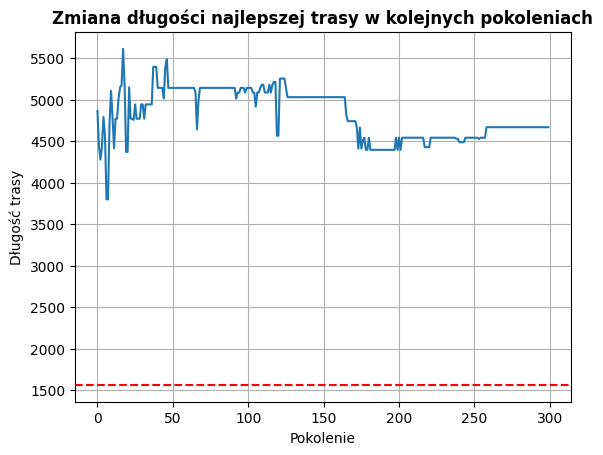

In [10]:
n_cities = 20
radius = 250
center = (0, 0)
cities = generate_cities(n=n_cities, radius=radius, center=center)

paths, distances, seconds = genetic_algorithm(
    cities,
    population_size=100,
    generations=300,
    crossover_rate=0.9,
    mutation_rate=0.05,
)

optimal_distance = optimal_path_distance(cities)

#create_route_animation(cities, paths, center, radius, filename="evolution.gif")
print(f"Czas pracy algorytmu: {seconds}s")
plt.plot(distances)
plt.axhline(optimal_distance, color='red', linestyle='--')
plt.title("Zmiana długości najlepszej trasy w kolejnych pokoleniach", fontweight='bold')
plt.xlabel("Pokolenie")
plt.ylabel("Długość trasy")
plt.grid(True)
plt.show()

#### **Analiza wyników**
Jak widać na powyższym wykresie algorytm nie działa poprawnie. W wielu przypadkach nowe pokolenie miało gorsze rezultaty niż ich rodzice, co jest niezgodne z całym zamysłem algorytmów genetycznych, które mają się poprawiać w czasie. W efekcie trasa zamiast się skracać oscyluje wokół początkowej długości.

Głębszy research na temat algorytmów genetycznych wykazał, że dobrym pomysłem może być wprowadzenie *elityzmu*, czyli zachowanie małej ilości najlepszych osobników z danej populacji do kolejnego pokolenia. Podczas krzyżowania tracimy najlepsze rozwiązania generacji, a jako iż jest to proces losowy to dochodzi do sytuacji, że bardzo dobry osobnik jest krzyżowany z bardzo słabym osobnikiem, więc osiągi ich dziecka również są słabe. Zachowanie nawet pojedynczego najlepszego osobnika dla następnego pokolenia eliminuje możliwość, że rezultaty będą się pogarszać. W najgorszym wypadku będą one stały w miejscu, ale na pewno trasa nie będzie się wydłużać.

Funkcja `genetic_algorithm_upgraded` modyfikuje pierwotny algorytm zachowując część generacji dla następnego pokolenia.

In [11]:
def genetic_algorithm_upgraded(
        cities,
        population_size=100,
        generations=500,
        crossover_rate=0.9,
        mutation_rate=0.05,
        elite_size=0.05
):
    start = time.time()
    population = initialize_population(len(cities), population_size)
    best_distances = []
    best_paths = []

    for gen in range(generations):

        routes = [calculate_distance(individual, cities) for individual in population]
        sorted_population = [x for _, x in sorted(zip(routes, population))]
        best_individual = sorted_population[0]

        best_distances.append(calculate_distance(best_individual, cities))
        best_paths.append(best_individual)

        elite_individuals = int(elite_size*len(sorted_population))
        new_population = sorted_population[:elite_individuals]

        while len(new_population) < population_size:
            parent1 = roulette_selection(population, routes)
            parent2 = roulette_selection(population, routes)

            if random.random() < crossover_rate:
                child = crossover(parent1, parent2)
            else:
                child = parent1[:]

            if random.random() < mutation_rate:
                child = mutate(child)

            new_population.append(child)

        population = new_population
    end = time.time()
    seconds = end - start

    return best_paths, best_distances, seconds

# **Uruchomienie programu - zachowanie 5% najleszych osobników**

Czas pracy algorytmu: 6.552025079727173s


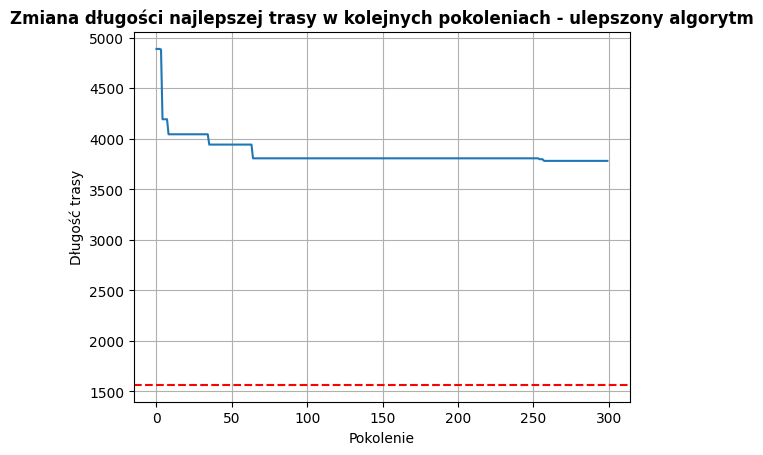

In [12]:
n_cities = 20
radius = 250
center = (0, 0)
cities = generate_cities(n=n_cities, radius=radius, center=center)

paths, distances, seconds = genetic_algorithm_upgraded(
    cities,
    population_size=100,
    generations=300,
    crossover_rate=0.9,
    mutation_rate=0.05,
    elite_size=0.05
)

optimal_distance = optimal_path_distance(cities)

#create_route_animation(cities, paths, center, radius, filename="evolution.gif")
print(f"Czas pracy algorytmu: {seconds}s")
plt.plot(distances)
plt.axhline(optimal_distance, color='red', linestyle='--')
plt.title("Zmiana długości najlepszej trasy w kolejnych pokoleniach - ulepszony algorytm", fontweight='bold')
plt.xlabel("Pokolenie")
plt.ylabel("Długość trasy")
plt.grid(True)
plt.show()

#### **Analiza wyników**
Jak widać algorytm działa dużo lepiej niż wcześniej i wyniki kierują się tylko w jedną stronę. W tym przypadku głównym problemem jest długotrwałe utknięcie w ekstremach lokalnych. Możliwym rozwiązaniem jest zwiększenie prawdopodobieństwa mutacji.

# **Uruchomienie algorytmu - zwiększona ilość mutacji**

Czas pracy algorytmu: 7.780708312988281s


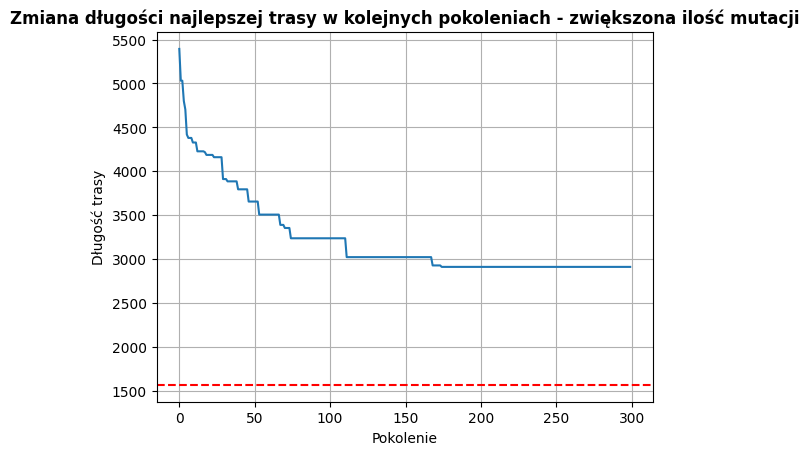

In [13]:
n_cities = 20
radius = 250
center = (0, 0)
cities = generate_cities(n=n_cities, radius=radius, center=center)

paths, distances, seconds = genetic_algorithm_upgraded(
    cities,
    population_size=100,
    generations=300,
    crossover_rate=0.9,
    mutation_rate=0.35,
    elite_size=0.05
)

optimal_distance = optimal_path_distance(cities)

#create_route_animation(cities, paths, center, radius, filename="evolution.gif")
print(f"Czas pracy algorytmu: {seconds}s")
plt.plot(distances)
plt.axhline(optimal_distance, color='red', linestyle='--')
plt.title("Zmiana długości najlepszej trasy w kolejnych pokoleniach - zwiększona ilość mutacji", fontweight='bold')
plt.xlabel("Pokolenie")
plt.ylabel("Długość trasy")
plt.grid(True)
plt.show()

#### **Analiza wyników**
Widać poprawę, lecz nadal występują przypadku długiego utknięcia w ekstremum lokalnym.

Funkcja `genetic_algorithm_dynamic_mutation` będzie dynamicznie zwiększać prawdopodobieństwo mutacji, jeśli przez 5 generacji wynik nie będzie się poprawiał.

In [14]:
def genetic_algorithm_dynamic_mutation(
        cities,
        population_size=100,
        generations=500,
        crossover_rate=0.9,
        mutation_rate=0.05,
        elite_size=0.05
):
    start = time.time()
    population = initialize_population(len(cities), population_size)
    best_distances = []
    best_paths = []
    initial_mutation_rate = mutation_rate
    stagnation_count = 0
    previous_best = 0

    for gen in range(generations):

        routes = [calculate_distance(individual, cities) for individual in population]
        sorted_population = [x for _, x in sorted(zip(routes, population))]
        best_individual = sorted_population[0]

        best_distance = calculate_distance(best_individual, cities)
        best_distances.append(best_distance)
        best_paths.append(best_individual)

        if previous_best == best_distance:
            stagnation_count += 1
            if stagnation_count >= 5:
              mutation_rate += 0.1
              stagnation_count = 0
        else:
            stagnation_count = 0

        previous_best = best_distance

        elite_individuals = int(elite_size*len(sorted_population))
        new_population = sorted_population[:elite_individuals]

        while len(new_population) < population_size:
            parent1 = roulette_selection(population, routes)
            parent2 = roulette_selection(population, routes)

            if random.random() < crossover_rate:
                child = crossover(parent1, parent2)
            else:
                child = parent1[:]

            if random.random() < mutation_rate:
                child = mutate(child)

            new_population.append(child)

        population = new_population

    end = time.time()
    seconds = end - start

    return best_paths, best_distances, seconds

# **Uruchomienie algorytmu - dynamiczna mutacja**

Czas pracy algorytmu: 7.686310291290283s


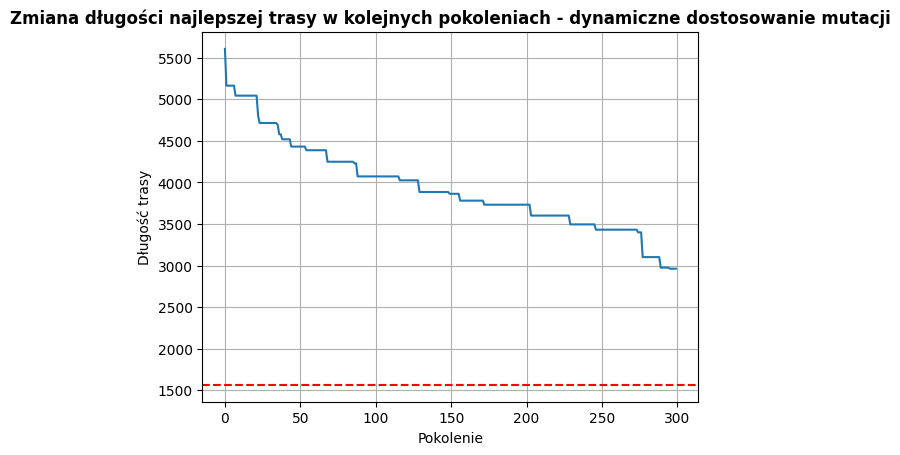

In [15]:
n_cities = 20
radius = 250
center = (0, 0)
cities = generate_cities(n=n_cities, radius=radius, center=center)

paths, distances, seconds = genetic_algorithm_dynamic_mutation(
    cities,
    population_size=100,
    generations=300,
    crossover_rate=0.9,
    mutation_rate=0.35,
    elite_size=0.05
)

optimal_distance = optimal_path_distance(cities)

create_route_animation(cities, paths, center, radius, filename="evolution.gif")
print(f"Czas pracy algorytmu: {seconds}s")
plt.plot(distances)
plt.axhline(optimal_distance, color='red', linestyle='--')
plt.title("Zmiana długości najlepszej trasy w kolejnych pokoleniach - dynamiczne dostosowanie mutacji", fontweight='bold')
plt.xlabel("Pokolenie")
plt.ylabel("Długość trasy")
plt.grid(True)
plt.show()

# **Podsumowanie**
Główynym czynnikiem, który ma wpływ na osiągi algorytmu jest zachowanie chociaż jednego najlepszego osobnika dla następnego pokolenia. Eliminuje to jakiekolwiek ryzyko, że wyniki będą się pogarszać w czasie. Bardzo małe prawdopodobieństwo mutacji niesie za sobą ryzyko długotrwałego utknięcia w ekstremum lokalnym, więc lepiej je trochę podnieść. Zarówno mutacja, jak i krzyżowanie są procesami losowymi, więc nie da się jednoznacznie stwierdzić jaki konkretny zakres tych wartości jest optymalny. Jeżeli ktoś jest tego ciekawy to można wykorzystać znaną już metodę Monte Carlo do sprawdzenia, czy jakieś konkretne zestawy parametrów będą szybciej od reszty znajdować optymalne rozwiązanie.